# Parse Music XML files instead
Sine Sat. Nov. 13th, 2021



`From Merry Go Round of Life` MIDI file is a challenging one if just to process the raw MIDI file,
due to quality of transcription, where there's slight times where time signature changes, and that comes with many tempos

Hopefully there's some way to process the symbolic representation in Music XML format,
as we need to get the bar separations,
i.e. each bar contains the corresponding notes


## Setup



In [1]:
import os

import pandas as pd
import music21
from icecream import ic

from util import *


m2u = Music21Util()



## music21

`From Merry Go Round of Life` MIDI file, exported using `MuseScore`


### Extract some note info example
From [Symbolic Format: MIDI](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C1/C1S2_MIDI.html)



In [2]:
# dset = 'MXL_EG'
# dir_nm = config(f'{DIR_DSET}.{dset}.dir_nm')
# dir_nm = os.path.join(PATH_BASE, DIR_DSET, dir_nm)
# fnm = os.path.join(dir_nm, 'Joe Hisaishi - Merry Go Round of Life (bitmidi).mxl')
fnm = eg_songs(k='Merry Go Round', fmt='MXL')
ic(fnm)


def get_notes(fl):
    # Modified from https://www.audiolabs-erlangen.de/resources/MIR/FMP/C1/C1S2_MusicXML.html
    """
    Convert a music xml file to a list of note events

    :param fl: MusicXML file path or `music21.stream.Score`
    :returns: score: List of `[start, duration, pitch, velocity, instrument]`
    """
    if isinstance(fl, str):
        fl = music21.converter.parse(fl)

    def _get_part(p_):
        instr = p_.getInstrument().instrumentName

        def _get(note_):
            strt = note_.offset
            dur_ = note_.quarterLength
            vol = note_.volume.realized
            def _one(pitch):
                return strt, dur_, pitch, vol, instr

            return [_one(p__.ps) for p__ in note_.pitches] if note_.isChord else [_one(note_.pitch.ps)]
        return flatten([_get(n_) for n_ in p_.flat.notes])
    notes = flatten([_get_part(p_) for p_ in fl.parts])
    return sorted(notes, key=lambda x: (x[0], x[2]))


lst_notes = get_notes(fnm)
df = pd.DataFrame(lst_notes, columns=['start', 'duration', 'pitch', 'velocity', 'instrument'])
ic(df.head(6))



ic| fnm: ('/Users/stefanh/Documents/UMich/Research/Music with NLP/datasets/MXL-eg/Joe '
          'Hisaishi - Merry Go Round of Life (bitmidi).mxl')
ic| df.head(6):   start duration  pitch  velocity instrument
                0   6.0      0.5   70.0       1.0      Piano
                1   6.0      0.5   74.0       1.0      Piano
                2   6.5      0.5   72.0       1.0      Piano
                3   6.5      0.5   75.0       1.0      Piano
                4   7.0      0.5   70.0       1.0      Piano
                5   7.0      0.5   74.0       1.0      Piano


,start,duration,pitch,velocity,instrument
0,6.0,0.5,70.0,1.0,Piano
1,6.0,0.5,74.0,1.0,Piano
2,6.5,0.5,72.0,1.0,Piano
3,6.5,0.5,75.0,1.0,Piano
4,7.0,0.5,70.0,1.0,Piano
5,7.0,0.5,74.0,1.0,Piano


### Parse an MXL
Following [User’s Guide, Chapter 6: Streams (II): Hierarchies, Recursion, and Flattening]
(https://web.mit.edu/music21/doc/usersGuide/usersGuide_06_stream2.html#accessing-scores-parts-measures-and-notes)



In [3]:
scr = music21.converter.parse(fnm)
ic(scr, type(scr), len(scr))
ic(vars(scr), dir(scr))
ic('\n')

for idx, elm in enumerate(scr):
    ic(idx, elm)
ic('\n')

for part in scr.parts:
    ic(part)
ic('\n')

for elm in list(scr.recurse())[:30]:
    ic(elm)



ic| scr: <music21.stream.Score 0x142707fd0>
    type(scr): <class 'music21.stream.base.Score'>
    len(scr): 6
ic| vars(scr): {'_activeSite': None,
                '_activeSiteStoredOffset': None,
                '_atSoundingPitch': 'unknown',
                '_cache': {},
                '_derivation': None,
                '_duration': None,
                '_editorial': None,
                '_elements': [<music21.metadata.Metadata object at 0x141c43a60>,
                              <music21.stream.Part Violin, CH #1>,
                              <music21.stream.Part Piano, CH #2>,
                              <music21.stream.Part Piano, CH #3>,
                              <music21.stream.Part Piano, CH #4>,
                              <music21.layout.ScoreLayout>],
                '_endElements': [],
                '_mutable': True,
                '_naiveOffset': 0.0,
                '_offsetDict': {5398346336: (0.0,
                                             <music21.

### How do I get the bars?
The **Accessing Scores, Parts, Measures, and Notes** section

#### `Part` in a `Score`

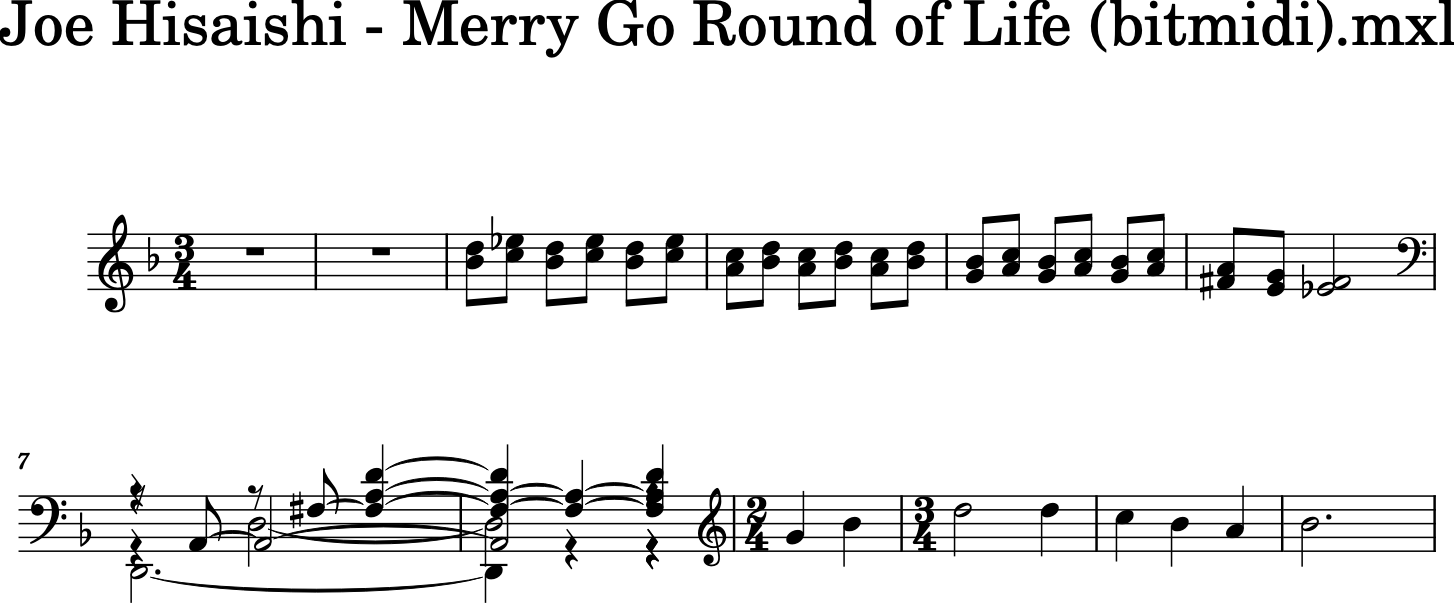

In [4]:
part_ch2: music21.stream.Part = scr[2]
# ic(part_ch2, vars(part_ch2))
part_ch2.show()



#### How does the part know the title in `show()`?
Looks like through `activeSite`



In [5]:
meta = scr.metadata
# ic(meta, vars(meta), vars_(meta))
ic(meta.title, meta.composer)


part_ch2 = scr[2]
ic(part_ch2, part_ch2.metadata)
# ic(vars(part_ch2), vars_(part_ch2))
ic(part_ch2.activeSite.metadata.title)



ic| meta.title: 'Joe Hisaishi - Merry Go Round of Life (bitmidi).mxl'
    meta.composer: None
ic| part_ch2: <music21.stream.Part Piano, CH #2>
    part_ch2.metadata: None
ic| part_ch2.activeSite.metadata.title: 'Joe Hisaishi - Merry Go Round of Life (bitmidi).mxl'


'Joe Hisaishi - Merry Go Round of Life (bitmidi).mxl'

#### `Bar` in a `Part`

ic| type(bar): <class 'music21.stream.base.Measure'>
    vars(bar): {'_activeSite': <weakref at 0x14281b6d0; to 'Part' at 0x142972f40>,
                '_activeSiteStoredOffset': 3.0,
                '_atSoundingPitch': 'unknown',
                '_cache': {},
                '_derivation': None,
                '_duration': None,
                '_editorial': None,
                '_elements': [<music21.note.Rest dotted-half>],
                '_endElements': [],
                '_mutable': True,
                '_naiveOffset': 0.0,
                '_offsetDict': {5412233712: (0.0, <music21.note.Rest dotted-half>)},
                '_priority': 0,
                '_style': None,
                '_unlinkedDuration': None,
                'autoSort': True,
                'clefIsNew': False,
                'definesExplicitPageBreaks': False,
                'definesExplicitSystemBreaks': False,
                'filled': False,
                'groups': ['P2'],
                'id': 541

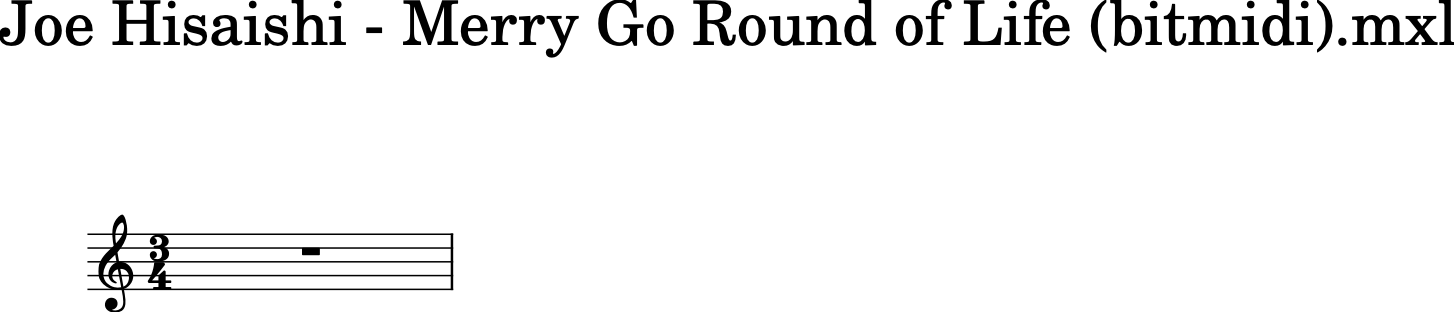

ic| bar.timeSignature: None
ic| bar: <music21.instrument.Piano 'P2: Piano, CH #2: Piano'>
ic| bar: <music21.stream.Measure 0 offset=0.0>
ic| bar: <music21.stream.Measure 1 offset=3.0>
ic| bar: <music21.stream.Measure 2 offset=6.0>
ic| bar: <music21.stream.Measure 3 offset=9.0>
ic| len(bars): 167
    type(bars): <class 'music21.stream.base.Part'>
    type(bars[0]): <class 'music21.instrument.Piano'>


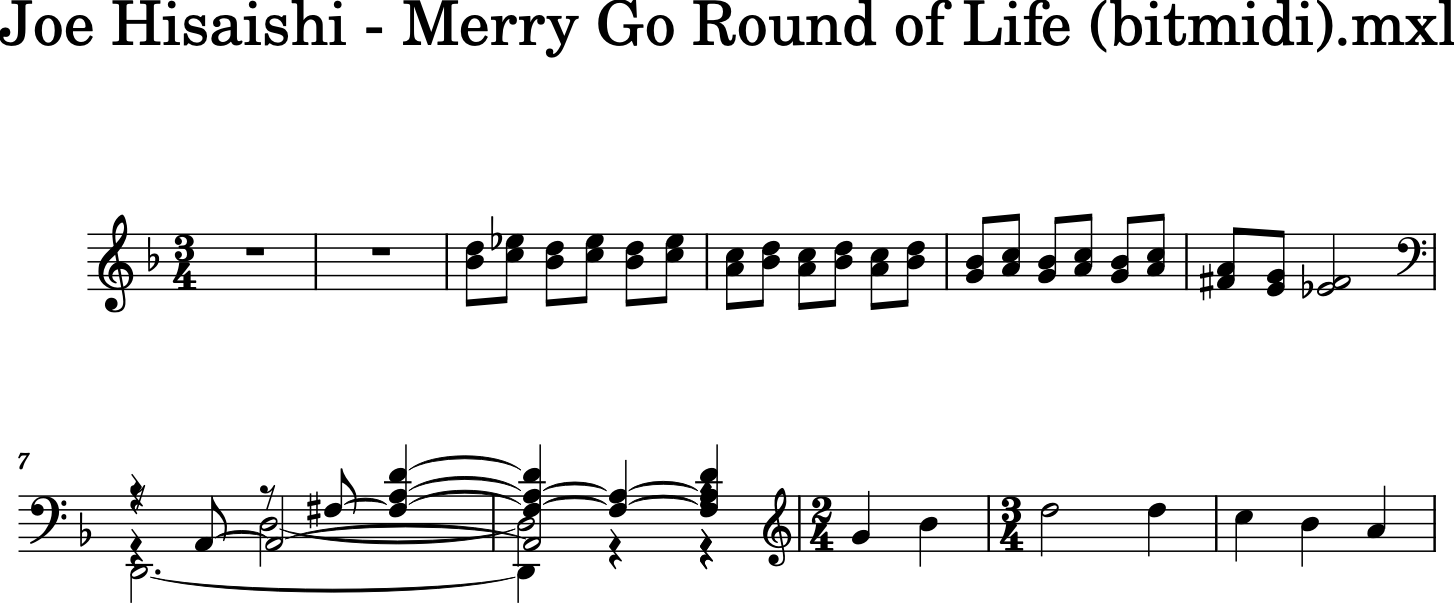

In [6]:
bar = part_ch2.measure(1)
ic(type(bar), vars(bar))
bar.show()
ic(bar.timeSignature)


bars = part_ch2.measures(numberStart=0, numberEnd=None)  # Get all measures
for bar in list(bars)[:5]:
    ic(bar)
    # ic(type(bar))

ic(len(bars), type(bars), type(bars[0]))
# ic(bars.show())
bars = part_ch2.measures(0, 10)
bars.show()



# Does all channels have the same number of measures?
Looks like the first/0-th measure of any part is always a special instrument measure?



In [7]:
for part in scr.parts:
    ic(len(part.measures(numberStart=0, numberEnd=None)))


part_ch1 = scr.parts[0]
for bar in part_ch1.measures(numberStart=0, numberEnd=10):
    ic(bar)



ic| len(part.measures(numberStart=0, numberEnd=None)): 167
ic| len(part.measures(numberStart=0, numberEnd=None)): 167
ic| len(part.measures(numberStart=0, numberEnd=None)): 167
ic| len(part.measures(numberStart=0, numberEnd=None)): 167
ic| bar: <music21.instrument.Violin 'P1: Violin, CH #1: Violin'>
ic| bar: <music21.stream.Measure 0 offset=0.0>
ic| bar: <music21.stream.Measure 1 offset=3.0>
ic| bar: <music21.stream.Measure 2 offset=6.0>
ic| bar: <music21.stream.Measure 3 offset=9.0>
ic| bar: <music21.stream.Measure 4 offset=12.0>
ic| bar: <music21.stream.Measure 5 offset=15.0>
ic| bar: <music21.stream.Measure 6 offset=18.0>
ic| bar: <music21.stream.Measure 7 offset=21.0>
ic| bar: <music21.stream.Measure 8 offset=24.0>
ic| bar: <music21.stream.Measure 9 offset=26.0>
ic| bar: <music21.stream.Measure 10 offset=29.0>


The MXL has a faulty time signature change,
### how is the time signature change parsed?



In [8]:
# for elm in part_ch1[:15]:  # Don't see it here?
#     ic(elm)
#     if isinstance(elm, music21.stream.Measure):
#         for e in elm:
#             ic(e)
for bar in part_ch1.measures(0, 10, collect=[]):  # Will contain only `Measure`s
    # ic(bar)
    ic(bar.timeSignature)


# ts = list(scr.recurse().getElementsByClass(music21.meter.TimeSignature))
ts = list(scr[music21.meter.TimeSignature])
ic(ts[:3])




ic| bar.timeSignature: <music21.meter.TimeSignature 3/4>
ic| bar.timeSignature: None
ic| bar.timeSignature: None
ic| bar.timeSignature: None
ic| bar.timeSignature: None
ic| bar.timeSignature: None
ic| bar.timeSignature: None
ic| bar.timeSignature: None
ic| bar.timeSignature: <music21.meter.TimeSignature 2/4>
ic| bar.timeSignature: <music21.meter.TimeSignature 3/4>
ic| bar.timeSignature: None
ic| ts[:3]: [<music21.meter.TimeSignature 3/4>,
             <music21.meter.TimeSignature 2/4>,
             <music21.meter.TimeSignature 3/4>]


[<music21.meter.TimeSignature 3/4>,
 <music21.meter.TimeSignature 2/4>,
 <music21.meter.TimeSignature 3/4>]

### Get the notes in a measure
#### A chord
We have the duration of each notes



ic| vars(bar): {'_activeSite': <weakref at 0x14281b6d0; to 'Part' at 0x142972f40>,
                '_activeSiteStoredOffset': 6.0,
                '_atSoundingPitch': 'unknown',
                '_cache': {'Duration': <music21.duration.Duration 3.0>,
                           'HighestTime': 3.0,
                           'elementTree-1940486242738374256': <ElementTree {0} (-inf to inf) <music21.stream.Measure 2 offset=6.0>>,
                           'elementTree-2867543565597770443': <ElementTree {0} (-inf to inf) <music21.stream.Measure 2 offset=6.0>>,
                           'elementTree-3882989310092426398': <ElementTree {0} (-inf to inf) <music21.stream.Measure 2 offset=6.0>>,
                           'elementTree3174967597905561897': <ElementTree {0} (-inf to inf) <music21.stream.Measure 2 offset=6.0>>,
                           'elementTree3203605587771887660': <ElementTree {0} (-inf to inf) <music21.stream.Measure 2 offset=6.0>>,
                           'elementTree3

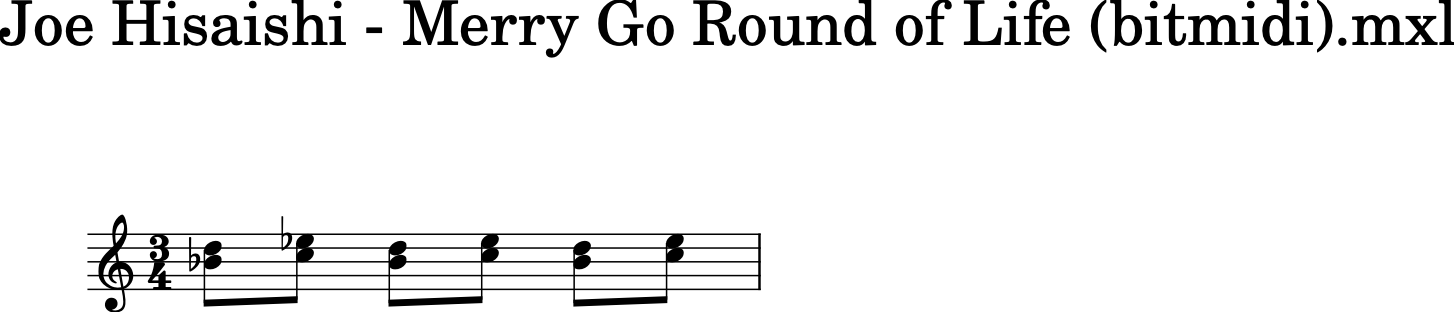

ic| len(bar.notes): 6
ic| chd: <music21.chord.Chord B-4 D5>
ic| chd: <music21.chord.Chord C5 E-5>
ic| chd: <music21.chord.Chord B-4 D5>
ic| chd: <music21.chord.Chord C5 E-5>
ic| chd: <music21.chord.Chord B-4 D5>
ic| chd: <music21.chord.Chord C5 E-5>
ic| chd.notes: (<music21.note.Note B->, <music21.note.Note D>)
ic| chd.fullName: 'Chord {B-flat in octave 4 | D in octave 5} Eighth'
ic| type(chd.duration): <class 'music21.duration.Duration'>
ic| dur: <music21.duration.Duration 0.5>


<music21.duration.Duration 0.5>

In [9]:
bar = part_ch2.measure(2)
ic(vars(bar), dir(bar))

bar.show()
ic(len(bar.notes)) # The 1st non-empty measure
for chd in bar.notes:
    ic(chd)

chd: music21.chord.Chord = bar.notes[0]  # A Chord, which contains multiple note
ic(chd.notes)
ic(chd.fullName)
# ic(vars(chd))
ic(type(chd.duration))
dur: music21.duration.Duration = chd.duration
ic(dur)  # 0.5 means half of time span of a quarter note



#### Notes in a chord



In [10]:
note: music21.note.Note = chd.notes[0]
ic(note)
ic(vars(note))



ic| note: <music21.note.Note B->
ic| vars(note): {'_activeSite': None,
                 '_activeSiteStoredOffset': None,
                 '_cache': {},
                 '_chordAttached': <music21.chord.Chord B-4 D5>,
                 '_derivation': <Derivation of <music21.note.Note B-> from None>,
                 '_duration': <music21.duration.Duration 0.5>,
                 '_editorial': None,
                 '_naiveOffset': 0.0,
                 '_notehead': 'normal',
                 '_noteheadFill': None,
                 '_noteheadParenthesis': False,
                 '_priority': 0,
                 '_stemDirection': 'down',
                 '_storedInstrument': None,
                 '_style': <music21.style.NoteStyle object at 0x1429822b0>,
                 '_volume': <music21.volume.Volume realized=1.0>,
                 'articulations': [],
                 'beams': <music21.beam.Beams>,
                 'expressions': [],
                 'groups': [],
                 'id

{'_activeSite': None,
 '_naiveOffset': 0.0,
 '_activeSiteStoredOffset': None,
 '_derivation': <Derivation of <music21.note.Note B-> from None>,
 '_style': <music21.style.NoteStyle object at 0x1429822b0>,
 '_editorial': None,
 '_duration': <music21.duration.Duration 0.5>,
 '_priority': 0,
 '_cache': {},
 'id': 6120621344,
 'groups': [],
 'sites': <music21.sites.Sites at 0x14298b9c0>,
 'lyrics': [],
 'expressions': [],
 'articulations': [],
 'tie': None,
 '_notehead': 'normal',
 '_noteheadFill': None,
 '_noteheadParenthesis': False,
 '_stemDirection': 'down',
 '_volume': <music21.volume.Volume realized=1.0>,
 'linkage': 'tie',
 'beams': <music21.beam.Beams>,
 '_storedInstrument': None,
 '_chordAttached': <music21.chord.Chord B-4 D5>,
 'pitch': <music21.pitch.Pitch B-4>}

#### Get notes start time relative to a measure?
Doesn't seem to be part of the `Note` object, is it inferred instead, based on the sequential ordering of `.notes`



In [11]:
# ic(note._naiveOffset)
ic(chd.offset)

ic(bar.notes[3].notes[1].offset)



ic| chd.offset: 0.0
ic| bar.notes[3].notes[1].offset: 0.0


0.0

##### Confirm assumption with another measure
Confirmed, seems like concurrent notes in the same time slot is clusted into a whole chord



In [12]:
bar = part_ch2.measure(5)
# m.show()

ic(len(bar.notes))
for chd in bar.notes:
    ic(chd, chd.duration, len(chd.notes))



ic| len(bar.notes): 3
ic| chd: <music21.chord.Chord F#4 A4>
    chd.duration: <music21.duration.Duration 0.5>
    len(chd.notes): 2
ic| chd: <music21.chord.Chord E4 G4>
    chd.duration: <music21.duration.Duration 0.5>
    len(chd.notes): 2
ic| chd: <music21.chord.Chord E-4 F#4>
    chd.duration: <music21.duration.Duration 2.0>
    len(chd.notes): 2


#### A chord has an offset instead
Looks like the correct `offset` is stored one level below the measure object, which makes sense



In [13]:
for chd in bar.notes:
    ic(chd, chd.offset)



ic| chd: <music21.chord.Chord F#4 A4>, chd.offset: 0.0
ic| chd: <music21.chord.Chord E4 G4>, chd.offset: 0.5
ic| chd: <music21.chord.Chord E-4 F#4>, chd.offset: 1.0


### Get pitch for a note
The numeric representation


In [14]:
part = note.pitch
# ic(vars(note))
ic(note, part)
ic(vars(part), dir(part))
ic(part.midi)


ic| note: <music21.note.Note B->, part: <music21.pitch.Pitch B-4>
ic| vars(part): {'_accidental': <music21.pitch.Accidental flat>,
                 '_client': <music21.note.Note B->,
                 '_groups': None,
                 '_microtone': None,
                 '_octave': 4,
                 '_overridden_freq440': None,
                 '_step': 'B',
                 'defaultOctave': 4,
                 'fundamental': None,
                 'spellingIsInferred': False}
    dir(part): ['_DOC_ATTR',
                '_DOC_ORDER',
                '__annotations__',
                '__class__',
                '__deepcopy__',
                '__delattr__',
                '__dict__',
                '__dir__',
                '__doc__',
                '__eq__',
                '__format__',
                '__ge__',
                '__getattribute__',
                '__gt__',
                '__hash__',
                '__init__',
                '__init_subclass__',
            

70

### Convert MIDI to MXL?
Not sure if there's any MXL datasets, but ideally, we can take advantage of the MIDI dataset


#### Can `music21` read in MIDI and process just like MXLs above?
Doesn't look great


ic| fnm: ('/Users/stefanh/Documents/UMich/Research/Music with NLP/datasets/MIDI-eg/Joe '
          'Hisaishi - Merry Go Round of Life (bitmidi).mid')
ic| scr: <music21.stream.Score 0x1425655b0>
ic| len(scr.parts): 4
ic| len(ms): 8


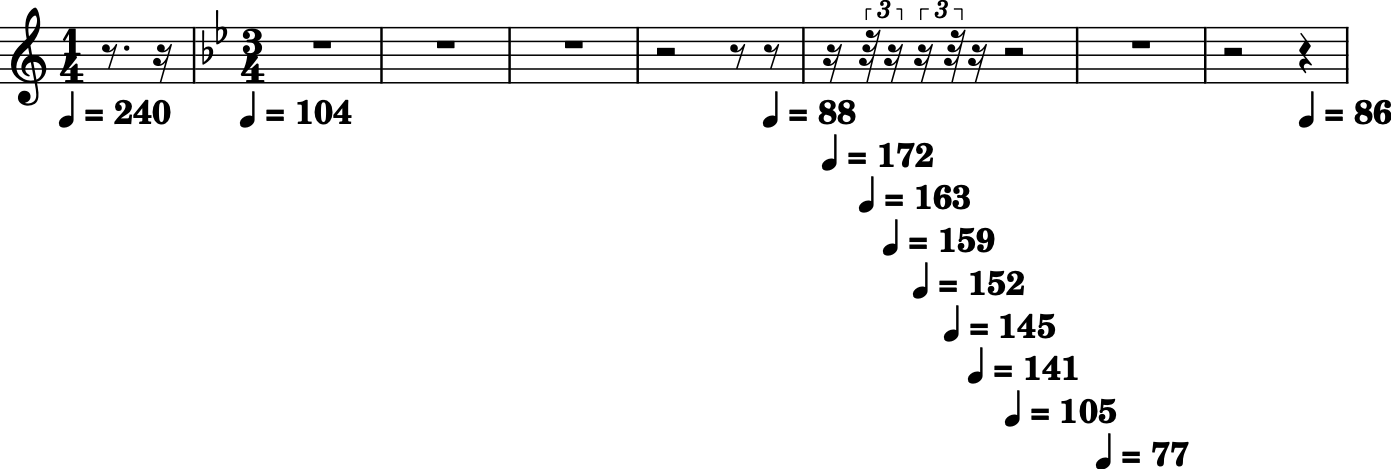

In [15]:
fnm = eg_songs(k='Merry Go Round', fmt='MIDI')
ic(fnm)

scr = music21.converter.parse(fnm)
ic(scr)
ic(len(scr.parts))
ms = scr.parts[0].measures(numberStart=0, numberEnd=8)
ic(len(ms))  # End exclusive
ms.show()



MuseScore-converted alternative above is better, so
#### Is there batch `MuseScore` MIDI=>MXL conversion interface in python?
Don't see one, but don't have to do it in python,
found a [batch processing plugin](https://musescore.org/en/project/batch-convert) for `MuseScore`


### Visualizing MXL with piano roll
#### How to show as in GUI, instead of an image?
Test the library, looks like `doneAction` is the answer


/usr/local/lib/python3.9/site-packages/music21/graph/primitives.py:932: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self.figure.subplots_adjust(left=0.15)


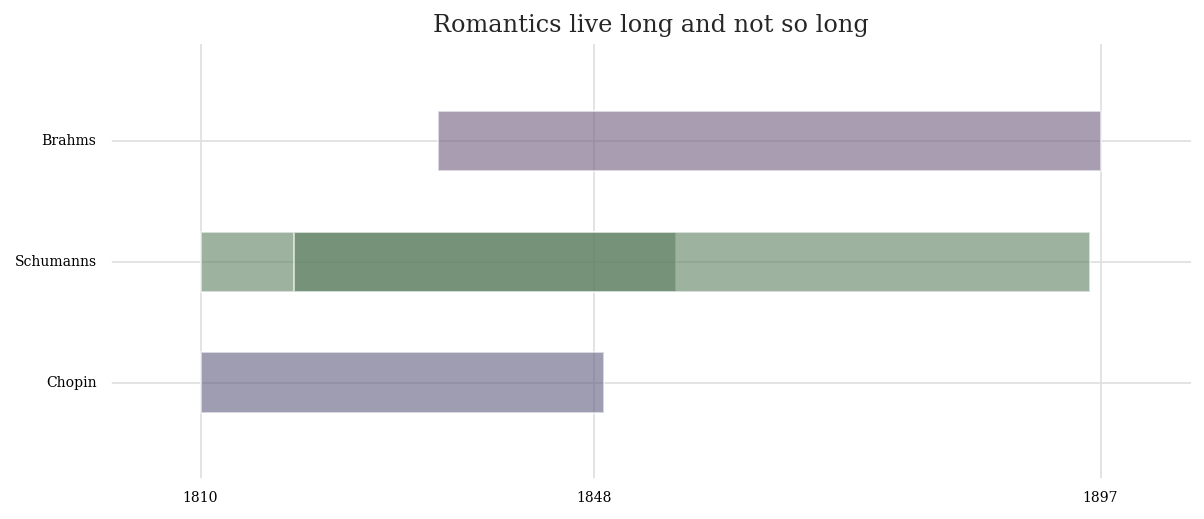

In [16]:
data = [('Chopin', [(1810, 1849 - 1810)]),
        ('Schumanns', [(1810, 1856 - 1810), (1819, 1896 - 1819)]),
        ('Brahms', [(1833, 1897 - 1833)])]
xTicks = [(1810, '1810'),
          (1848, '1848'),
          (1897, '1897')]
ghb = music21.graph.primitives.GraphHorizontalBar()
ghb.title = 'Romantics live long and not so long'
ghb.data = data
ghb.setTicks('x', xTicks)

ghb.doneAction = None  # The `show` action calls figure.show() which doesn't seem to work in Pycharm
ghb.process()
# ghb.callDoneAction()
plt.show()




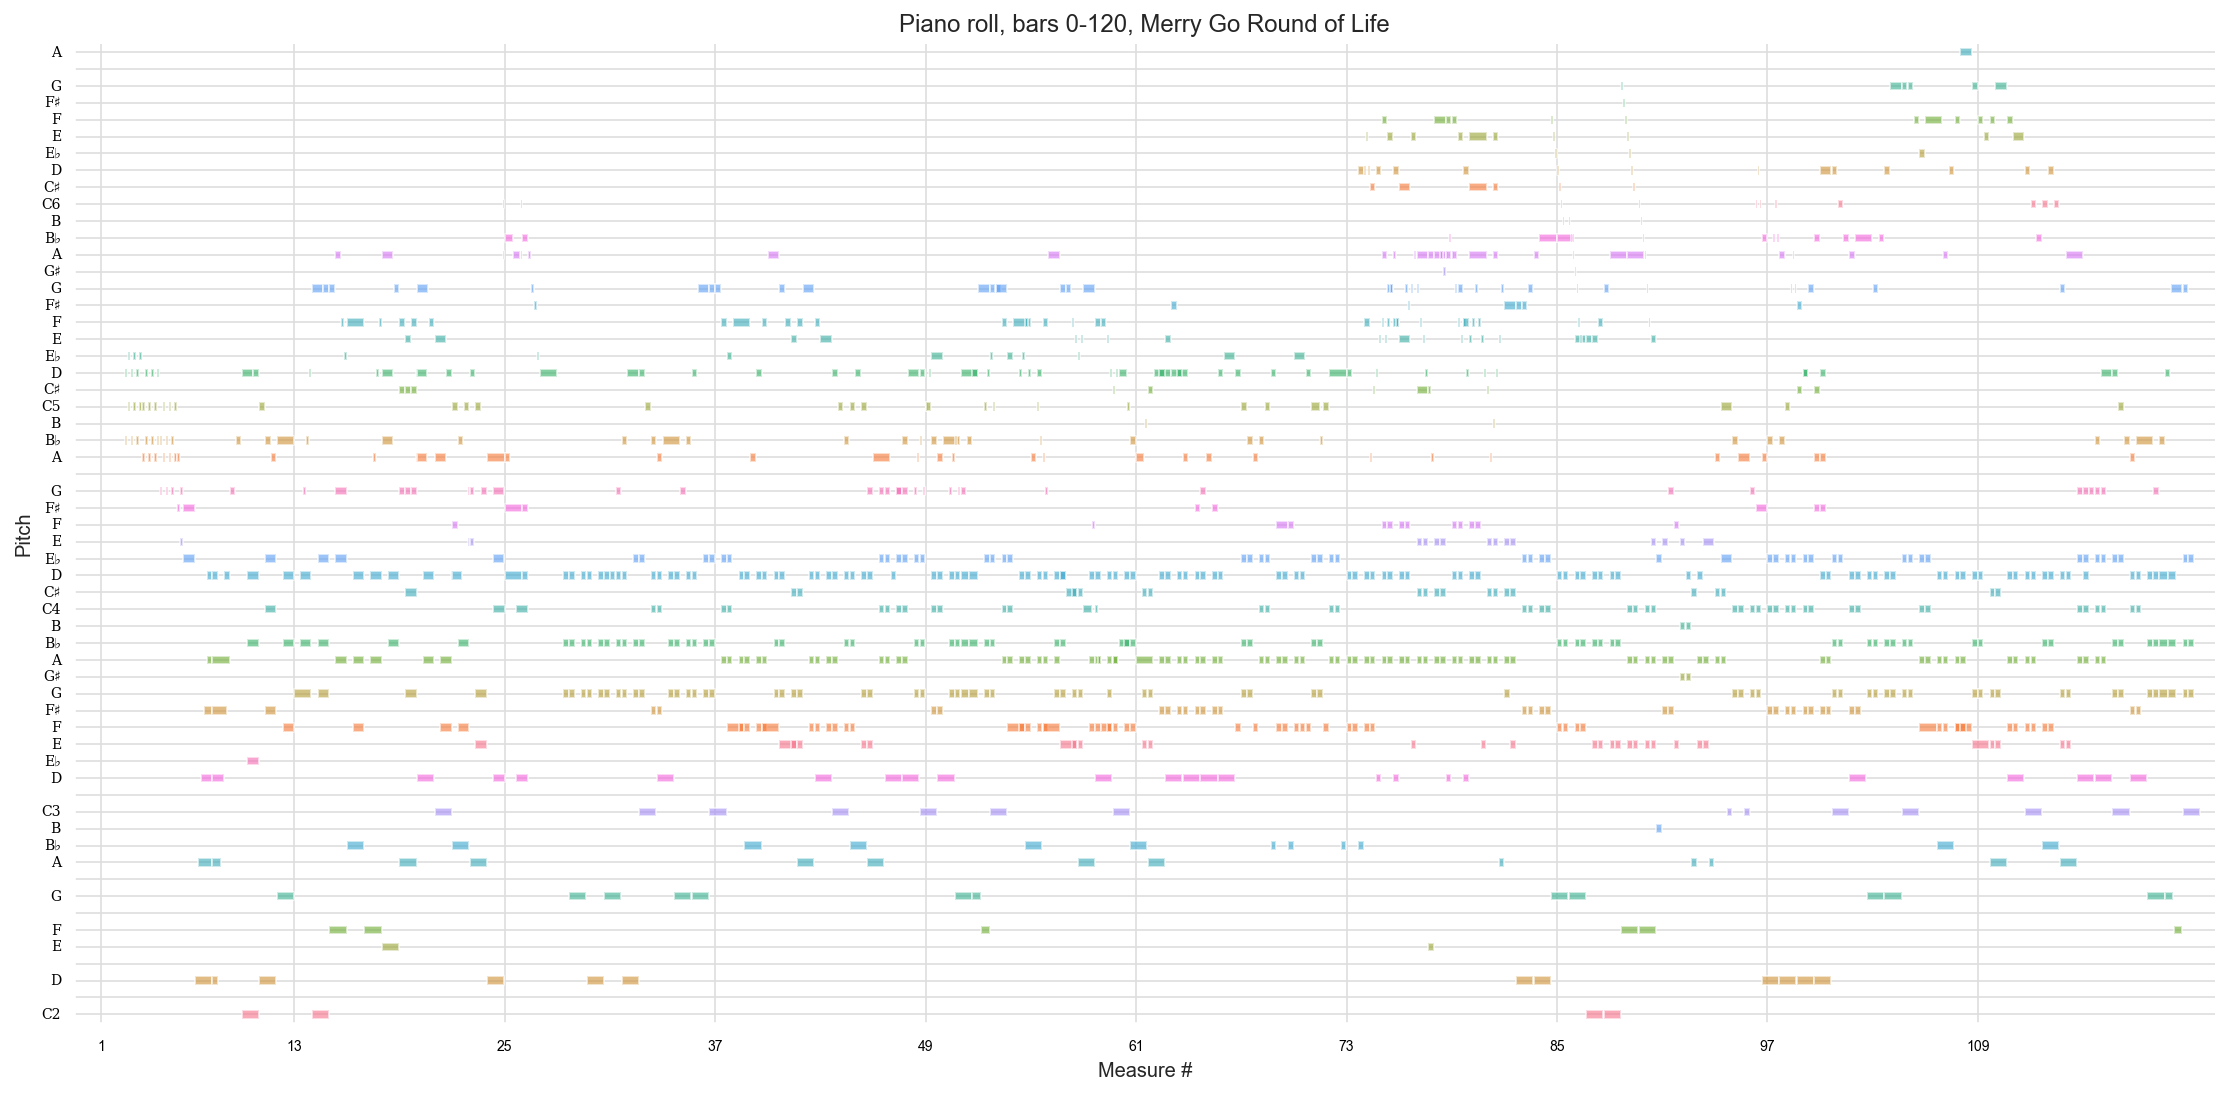

ic| r: <music21.graph.plot.HorizontalBarPitchSpaceOffset for <music21.stream.Score 0x14276ff40>>


<music21.graph.plot.HorizontalBarPitchSpaceOffset for <music21.stream.Score 0x14276ff40>>

In [17]:
r = m2u.plot_piano_roll(scr, title='Merry Go Round of Life', e=120)
ic(r)


